## EfficientNetB5

In this notebook, our team evaluates the performance of EfficientNetB5 on our dataset, served as the baseline evaluation.

**This notebook contains the following sections:**
1. Loading Preprocessed Dataset
2. EfficientNet‑B5 model architecture   
3. Hyperparameter Tuning  
4. Model Training
5. Model Evaluation

**Assumed project structure:**
```markdown
ROOT
├── notebooks
│   └── EfficientNetB5.ipynb
└── input
    └── final_split_15Apr2025
        ├── train
        ├── eval
        └── test
```
* if dataset not downloaded, dataset would download in the loading dataset section.

References: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **model_name (str)**: Abbreviation or identifier for the model being trained (used for file naming).
- **batch_size (int)**: Number of samples per training/validation batch.

In [1]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
final_data_set = "final_split_15Apr2025"
root_result_folder = "results"
model_directory = "models" 
google_drive_id = "1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"

model_name = "FINAL_EfficientNetB5" # Name of the model that the file is training in abbreviation
batch_size = 64 # State the number of datapoints in each batch size

## Imports

Used to handle the imports

In [2]:
from typing import List, Optional, Callable
import os
import sys
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

## Loading Dataset and File Location Variables

Global Variables Created:
- **PROJECT_ROOT (str)**: Absolute path to the project’s root directory; added to `sys.path` for imports.
- **LOG_DIR (str)**: Path to the directory where log files will be written.
- **MODEL_SAVE_DIR (str)**: Directory for saving model checkpoints and final trained model files.
- **CHECKPOINT_DIR (str)**: Directory where intermediate checkpoints for hyperparameter tuning are stored.
- **RESULTS_DIR (str)**: Path to store evaluation results and metrics, separated by model name.
- **BEST_MODEL_PATH (str)**: Full path to the file where the best-performing model will be saved.
- **DATASET_FOLDER (str)**: Full path to the folder containing the dataset used for training.
- **DEVICE (torch.device)**: The hardware device selected for training ('cuda', 'mps', or 'cpu').


In [3]:
# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")
logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
print(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)

# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

c:\Users\Ning\DogEmotionADL\results/FINAL_EfficientNetB5
Using device: CUDA (GPU)


### Download Dataset

In [4]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id={google_drive_id}",  F"{DATASET_FOLDER}.zip", "../input")

Downloading...
From (original): https://drive.google.com/uc?id=1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg
From (redirected): https://drive.google.com/uc?id=1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg&confirm=t&uuid=cd028792-f30b-4506-a0c7-d93a9a2f452d
To: c:\Users\Ning\DogEmotionADL\input\final_split_15Apr2025.zip
100%|██████████| 95.5M/95.5M [00:06<00:00, 15.6MB/s]


Extracting dataset...
Extraction complete. Dataset available at final_split_15Apr2025


### Loading Dataset

In [5]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("LOADING SUBSET DATASET-----------------------------------------------------")
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
    subset_fraction=0.5,
    random_seed=42
)
print("LOADING FULL DATASET-------------------------------------------------------")
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
)

LOADING SUBSET DATASET-----------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
LOADING FULL DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification
This part of the file will change largely based on each of the models that are being created

In [6]:
class BaseEfficientNetB5(nn.Module):
    """EfficientNetB5 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained EfficientNetB5 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.backbone.classifier[1] = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [7]:
print(f"Using device: {DEVICE}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.

In [8]:
def train_model(config, device=DEVICE, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()
            running_total   += targets.size(0) 
        
        epoch_loss = running_loss / running_total
        epoch_acc  = running_correct / running_total
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total   += targets.size(0)
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc})

In [ ]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,
    grace_period=2,    
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try
# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-4, 1e-2),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        # lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 4, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="baseefficientnetb5_final",
        storage_path="C:/ray_results/baseefficientnetb5_final", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min",filter_nan_and_inf=False).config)

best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=992) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 1: loss=1.1957 acc=0.476


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 2: loss=0.8904 acc=0.651


Epoch 3/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=992) [TRAIN] epoch 3: loss=0.8833 acc=0.641


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 4: loss=0.8344 acc=0.667


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 5: loss=0.8259 acc=0.675


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 6: loss=0.8152 acc=0.680


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 7: loss=0.8251 acc=0.670


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 8: loss=0.8133 acc=0.673


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=992) [TRAIN] epoch 9: loss=0.8048 acc=0.683


Epoch 10/10: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


(train_model pid=992) [TRAIN] epoch 10: loss=0.8029 acc=0.684


2025-04-20 20:52:53,918	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=992) [VAL] loss=0.7874 acc=0.685
(train_model pid=30056) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30056) [TRAIN] epoch 1: loss=1.3855 acc=0.267


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30056) [TRAIN] epoch 2: loss=1.3809 acc=0.290


Epoch 3/10: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


(train_model pid=30056) [TRAIN] epoch 3: loss=1.3761 acc=0.305


Epoch 4/10: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


(train_model pid=30056) [TRAIN] epoch 4: loss=1.3702 acc=0.321


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30056) [TRAIN] epoch 5: loss=1.3661 acc=0.349


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30056) [TRAIN] epoch 6: loss=1.3636 acc=0.347


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30056) [TRAIN] epoch 7: loss=1.3582 acc=0.374


Epoch 8/10: 100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


(train_model pid=30056) [TRAIN] epoch 8: loss=1.3543 acc=0.388


Epoch 9/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


(train_model pid=30056) [TRAIN] epoch 9: loss=1.3474 acc=0.408


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=30056) [TRAIN] epoch 10: loss=1.3413 acc=0.414


2025-04-20 21:00:25,465	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=30056) [VAL] loss=1.3370 acc=0.491
(train_model pid=38100) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 1: loss=1.4108 acc=0.253


Epoch 2/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.42it/s]


(train_model pid=38100) [TRAIN] epoch 2: loss=1.4108 acc=0.248


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 3: loss=1.4097 acc=0.243


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 4: loss=1.4074 acc=0.241


Epoch 5/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=38100) [TRAIN] epoch 5: loss=1.4067 acc=0.259


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 6: loss=1.4040 acc=0.257


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 7: loss=1.4049 acc=0.250


Epoch 8/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=38100) [TRAIN] epoch 8: loss=1.4003 acc=0.261


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38100) [TRAIN] epoch 9: loss=1.4048 acc=0.255


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=38100) [TRAIN] epoch 10: loss=1.4003 acc=0.274


2025-04-20 21:07:53,815	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=38100) [VAL] loss=1.3855 acc=0.260
(train_model pid=28932) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 1: loss=1.1785 acc=0.478


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 2: loss=0.8510 acc=0.656


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 3: loss=0.7975 acc=0.683


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 4: loss=0.7520 acc=0.693


Epoch 5/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=28932) [TRAIN] epoch 5: loss=0.7184 acc=0.709


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 6: loss=0.6990 acc=0.722


Epoch 7/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=28932) [TRAIN] epoch 7: loss=0.6567 acc=0.744


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28932) [TRAIN] epoch 8: loss=0.6406 acc=0.746


Epoch 9/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=28932) [TRAIN] epoch 9: loss=0.6203 acc=0.762


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=28932) [TRAIN] epoch 10: loss=0.5901 acc=0.771


2025-04-20 21:15:23,321	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28932) [VAL] loss=0.7041 acc=0.709
(train_model pid=20088) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 1: loss=1.1020 acc=0.531


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 2: loss=0.9592 acc=0.616


Epoch 3/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.41it/s]


(train_model pid=20088) [TRAIN] epoch 3: loss=0.9449 acc=0.615


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 4: loss=0.9161 acc=0.626


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 5: loss=0.9069 acc=0.637


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 6: loss=0.8980 acc=0.643


Epoch 7/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=20088) [TRAIN] epoch 7: loss=0.9190 acc=0.629


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 8: loss=0.8669 acc=0.637


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20088) [TRAIN] epoch 9: loss=0.8852 acc=0.643


Epoch 10/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=20088) [TRAIN] epoch 10: loss=0.8930 acc=0.641


2025-04-20 21:22:53,702	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=20088) [VAL] loss=0.8149 acc=0.692
(train_model pid=3168) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3168) [TRAIN] epoch 1: loss=1.3402 acc=0.343


Epoch 2/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=3168) [TRAIN] epoch 2: loss=1.0686 acc=0.548


Epoch 3/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=3168) [TRAIN] epoch 3: loss=0.9452 acc=0.606


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3168) [TRAIN] epoch 4: loss=0.8784 acc=0.648


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3168) [TRAIN] epoch 5: loss=0.8564 acc=0.649


Epoch 6/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.42it/s]


(train_model pid=3168) [TRAIN] epoch 6: loss=0.8457 acc=0.656


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3168) [TRAIN] epoch 7: loss=0.8374 acc=0.663


Epoch 8/10: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


(train_model pid=3168) [TRAIN] epoch 8: loss=0.8380 acc=0.670


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3168) [TRAIN] epoch 9: loss=0.8176 acc=0.674


Epoch 10/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=3168) [TRAIN] epoch 10: loss=0.8152 acc=0.674


2025-04-20 21:30:23,520	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=3168) [VAL] loss=0.7927 acc=0.678
(train_model pid=18008) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 1: loss=1.2886 acc=0.443


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 2: loss=0.9820 acc=0.605


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 3: loss=0.8821 acc=0.642


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 4: loss=0.8210 acc=0.668


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 5: loss=0.8294 acc=0.671


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 6: loss=0.8066 acc=0.676


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 7: loss=0.7819 acc=0.695


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 8: loss=0.7787 acc=0.696


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=18008) [TRAIN] epoch 9: loss=0.7660 acc=0.690


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


(train_model pid=18008) [TRAIN] epoch 10: loss=0.7418 acc=0.709


2025-04-20 21:37:55,167	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=18008) [VAL] loss=0.7422 acc=0.692
(train_model pid=17884) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17884) [TRAIN] epoch 1: loss=1.3860 acc=0.242


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17884) [TRAIN] epoch 2: loss=1.3829 acc=0.286


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17884) [TRAIN] epoch 3: loss=1.3804 acc=0.318


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17884) [TRAIN] epoch 4: loss=1.3775 acc=0.333


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17884) [TRAIN] epoch 5: loss=1.3731 acc=0.354


Epoch 6/10: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


(train_model pid=17884) [TRAIN] epoch 6: loss=1.3693 acc=0.372


Epoch 7/10: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


(train_model pid=17884) [TRAIN] epoch 7: loss=1.3645 acc=0.395


Epoch 8/10: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


(train_model pid=17884) [TRAIN] epoch 8: loss=1.3581 acc=0.412


Epoch 9/10: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


(train_model pid=17884) [TRAIN] epoch 9: loss=1.3508 acc=0.425


Epoch 10/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


(train_model pid=17884) [TRAIN] epoch 10: loss=1.3415 acc=0.438


2025-04-20 21:45:35,388	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=17884) [VAL] loss=1.3354 acc=0.422
(train_model pid=38232) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [00:45<00:00,  1.36it/s]


(train_model pid=38232) [TRAIN] epoch 1: loss=1.1777 acc=0.460


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 2: loss=0.9526 acc=0.607


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 3: loss=0.8686 acc=0.649


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 4: loss=0.8316 acc=0.667


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 5: loss=0.8007 acc=0.681


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 6: loss=0.8066 acc=0.674


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 7: loss=0.7776 acc=0.692


Epoch 8/10: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


(train_model pid=38232) [TRAIN] epoch 8: loss=0.7523 acc=0.696


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38232) [TRAIN] epoch 9: loss=0.7535 acc=0.697


Epoch 10/10: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


(train_model pid=38232) [TRAIN] epoch 10: loss=0.7520 acc=0.709


2025-04-20 21:53:23,527	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=38232) [VAL] loss=0.7746 acc=0.675
(train_model pid=36192) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


(train_model pid=36192) [TRAIN] epoch 1: loss=1.3874 acc=0.244


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 2: loss=1.3864 acc=0.252


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 3: loss=1.3861 acc=0.254


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 4: loss=1.3857 acc=0.257


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 5: loss=1.3856 acc=0.254


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 6: loss=1.3849 acc=0.262


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 7: loss=1.3852 acc=0.262


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=36192) [TRAIN] epoch 8: loss=1.3853 acc=0.258


Epoch 9/10:  98%|█████████▊| 62/63 [00:44<00:00,  1.38it/s]


(train_model pid=36192) [TRAIN] epoch 9: loss=1.3846 acc=0.269


Epoch 10/10: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


(train_model pid=36192) [TRAIN] epoch 10: loss=1.3833 acc=0.282


2025-04-20 22:01:07,372	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=36192) [VAL] loss=1.3840 acc=0.249
(train_model pid=20996) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 1: loss=1.3864 acc=0.258


Epoch 2/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


(train_model pid=20996) [TRAIN] epoch 2: loss=1.3849 acc=0.271


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 3: loss=1.3835 acc=0.278


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 4: loss=1.3836 acc=0.279


Epoch 5/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


(train_model pid=20996) [TRAIN] epoch 5: loss=1.3819 acc=0.290


Epoch 6/10: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s]


(train_model pid=20996) [TRAIN] epoch 6: loss=1.3799 acc=0.306


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 7: loss=1.3789 acc=0.323


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 8: loss=1.3779 acc=0.321


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=20996) [TRAIN] epoch 9: loss=1.3756 acc=0.346


Epoch 10/10: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


(train_model pid=20996) [TRAIN] epoch 10: loss=1.3744 acc=0.352


2025-04-20 22:08:52,291	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=20996) [VAL] loss=1.3716 acc=0.450
(train_model pid=38456) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 1: loss=1.1498 acc=0.524


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 2: loss=0.9197 acc=0.661


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 3: loss=0.8389 acc=0.686


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 4: loss=0.8022 acc=0.695


Epoch 5/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=38456) [TRAIN] epoch 5: loss=0.7866 acc=0.699


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 6: loss=0.7627 acc=0.698


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 7: loss=0.7399 acc=0.714


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 8: loss=0.7304 acc=0.711


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38456) [TRAIN] epoch 9: loss=0.7253 acc=0.719


Epoch 10/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=38456) [TRAIN] epoch 10: loss=0.7290 acc=0.727


2025-04-20 22:16:25,944	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=38456) [VAL] loss=0.7688 acc=0.706
(train_model pid=35796) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 1: loss=1.3745 acc=0.300


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 2: loss=1.3237 acc=0.395


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 3: loss=1.2808 acc=0.465


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 4: loss=1.2456 acc=0.496


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 5: loss=1.2147 acc=0.520


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 6: loss=1.1854 acc=0.548


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 7: loss=1.1584 acc=0.560


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=35796) [TRAIN] epoch 8: loss=1.1351 acc=0.577


Epoch 9/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.42it/s]


(train_model pid=35796) [TRAIN] epoch 9: loss=1.1101 acc=0.599


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=35796) [TRAIN] epoch 10: loss=1.0918 acc=0.600


2025-04-20 22:23:54,986	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=35796) [VAL] loss=1.0973 acc=0.619
(train_model pid=38632) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 1: loss=1.2977 acc=0.413


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 2: loss=1.1375 acc=0.564


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 3: loss=1.0560 acc=0.599


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 4: loss=0.9974 acc=0.634


Epoch 5/10: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


(train_model pid=38632) [TRAIN] epoch 5: loss=0.9523 acc=0.643


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 6: loss=0.9177 acc=0.656


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 7: loss=0.8951 acc=0.666


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 8: loss=0.8867 acc=0.654


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=38632) [TRAIN] epoch 9: loss=0.8634 acc=0.676


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


(train_model pid=38632) [TRAIN] epoch 10: loss=0.8516 acc=0.678


2025-04-20 22:31:25,285	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=38632) [VAL] loss=0.8670 acc=0.654
(train_model pid=30332) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 1: loss=1.3064 acc=0.425


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 2: loss=0.9883 acc=0.608


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 3: loss=0.8399 acc=0.670


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 4: loss=0.7846 acc=0.693


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 5: loss=0.7374 acc=0.702


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 6: loss=0.7286 acc=0.700


Epoch 7/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.42it/s]


(train_model pid=30332) [TRAIN] epoch 7: loss=0.7040 acc=0.723


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 8: loss=0.6944 acc=0.723


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30332) [TRAIN] epoch 9: loss=0.6754 acc=0.735


Epoch 10/10:  98%|█████████▊| 62/63 [00:43<00:00,  1.43it/s]


(train_model pid=30332) [TRAIN] epoch 10: loss=0.6503 acc=0.742


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]
2025-04-20 22:38:55,031	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-20 22:38:55,052	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/baseefficientnetb5_final/baseefficientnetb5_final' in 0.0185s.


(train_model pid=30332) [VAL] loss=0.7257 acc=0.696


2025-04-20 22:38:55,069	INFO tune.py:1041 -- Total run time: 6830.76 seconds (6830.69 seconds for the tuning loop).


Best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001C23F6F2E60>, 'criterion': <function <lambda> at 0x000001C240CB01F0>}
Full best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001C23F6F2E60>, 'criterion': <function <lambda> at 0x000001C240CB01F0>}


## Final Model Training

In [ ]:
#### Good configs, saved after various experimentations
# This cell can be skipped if hyper parameter tuning was run
# best_config = {
#     'lr': 0.0007591104805282694,
#     'weight_decay': 1.7541893487450798e-05,
#     'dropout': 0.399035382022254,
#     'hidden_sizes': [512, 256],
#     'activation': 'relu',
#     'freeze_backbone': True,
#     'num_epochs': 10,
#     'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
#     'criterion': lambda: nn.CrossEntropyLoss()
# }

In [11]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

print(optimiser)
print(criterion)

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0007591104805282694
    maximize: False
    weight_decay: 1.7541893487450798e-05
)
CrossEntropyLoss()


In [12]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []
train_accs   = [] 
val_accs     = [] 

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct+= (predicted == targets).sum().item()
        running_total  += targets.size(0)
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs, 1)
            running_val_loss += loss.item() * inputs.size(0)
            val_correct     += (predicted == targets).sum().item()
            val_total       += targets.size(0)
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.3f} | Val Loss: {epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.3f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        torch.save(final_model.state_dict(), BEST_MODEL_PATH)
        logging.info("Model saved to: %s",  {BEST_MODEL_PATH})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 1.0526, Train Acc=0.553 | Val Loss: 1.0597, Val Acc=0.582


Epoch 2/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.8304, Train Acc=0.665 | Val Loss: 0.8394, Val Acc=0.661


Epoch 3/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.7799, Train Acc=0.685 | Val Loss: 0.7138, Val Acc=0.712


Epoch 4/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.7286, Train Acc=0.707 | Val Loss: 0.7069, Val Acc=0.713


Epoch 5/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.7053, Train Acc=0.715 | Val Loss: 0.7100, Val Acc=0.693


Epoch 6/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.6666, Train Acc=0.738 | Val Loss: 0.7366, Val Acc=0.699


Epoch 7/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.6294, Train Acc=0.745 | Val Loss: 0.7238, Val Acc=0.710


Epoch 8/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.6056, Train Acc=0.762 | Val Loss: 0.6867, Val Acc=0.718


Epoch 9/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.5613, Train Acc=0.780 | Val Loss: 0.6950, Val Acc=0.717


Epoch 10/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.5400, Train Acc=0.788 | Val Loss: 0.6567, Val Acc=0.720


Epoch 11/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.5134, Train Acc=0.808 | Val Loss: 0.6742, Val Acc=0.736


Epoch 12/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.4994, Train Acc=0.807 | Val Loss: 0.6867, Val Acc=0.725


Epoch 13/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.4758, Train Acc=0.816 | Val Loss: 0.7070, Val Acc=0.736


Epoch 14/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.4757, Train Acc=0.821 | Val Loss: 0.6570, Val Acc=0.748


Epoch 15/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.4369, Train Acc=0.834 | Val Loss: 0.6965, Val Acc=0.744
Early stopping triggered.


## Testing

Test Loss: 0.6131, Test Accuracy: 77.62%


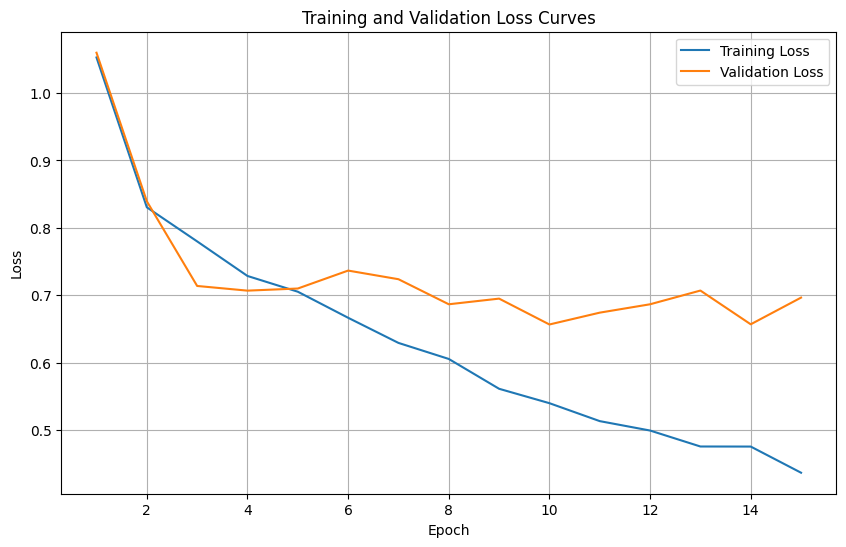

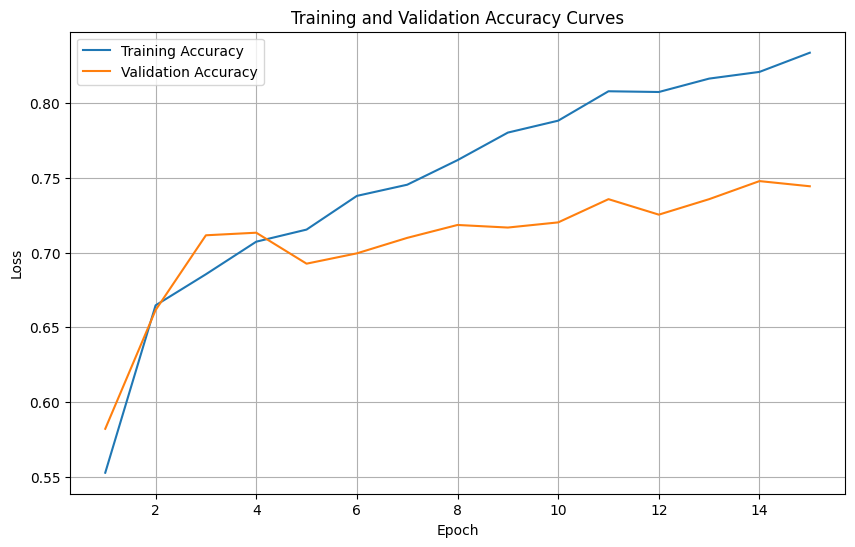


Classification Report:
               precision    recall  f1-score   support

       angry       0.89      0.75      0.81       140
       happy       0.77      0.80      0.79       148
     relaxed       0.65      0.75      0.70       146
         sad       0.85      0.80      0.82       138

    accuracy                           0.78       572
   macro avg       0.79      0.78      0.78       572
weighted avg       0.79      0.78      0.78       572


 F1 score: 0.7796850642569092; 
 Precision score: 0.7886534660191976; 
 Recall Score: 0.7761450402159157


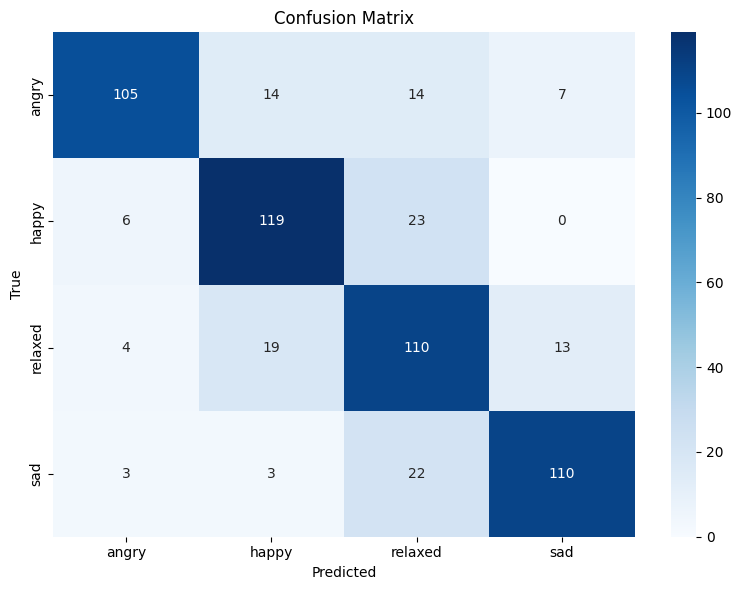

In [13]:
# load best model from training
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(RESULTS_DIR, "loss_curves.png")
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# plotting training and validation acc curves
if 'train_accs' in globals() and 'val_accs' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy")
    plt.plot(range(1, len(val_accs)+1), val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    acc_curve_path = os.path.join(RESULTS_DIR, "accuracy_curves.png")
    plt.savefig(acc_curve_path)
    plt.show()
    logging.info("Training and Validation Accuracy curves saved to %s", acc_curve_path)
else:
    logging.warning("train_accs and val_accs are not defined. Skipping accuracy curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)